In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import math

In [2]:
# all values between 0 and 1
file = r'carbon_nanotubes.csv'
df = pd.read_csv(file, delimiter=';', header=None, decimal=',', skiprows=1)
x_train = df.drop([0,1], axis=1).values

In [3]:
print('data shape: ', x_train.shape)
m = x_train.shape[0]
n = x_train.shape[1]
print('No of training examples: ', m)
print('No of features: ', n)

data shape:  (10721, 6)
No of training examples:  10721
No of features:  6


In [6]:
def random_mini_batch(X, Y, mini_batch_size = None):
    '''Created minibatches for feeding into NN. First the dataset if randomized and then mini batches are
    made from the randomized set.
    
    Arguments:
    X -- array, shape(m, n)
    Y -- array, shape depends on how many classes. If it is binary then it is a vector.
    
    Return:
    mini_batches -- list of tuples which contain arrays.'''
    
    if mini_batch_size==None:
        return print('Need to specify a mini_batch_size.')
    else: 
        m = X.shape[0]
        
        mini_batches = []
         
        # shuffle (X, Y)
        permutation = list(np.random.permutation(m))
        shuffled_X = X[permutation, :]
        shuffled_Y = Y[permutation, :]#.reshape(m,1) if this was a label vector of shape(m, 1)
        
        # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
        num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
        for k in range(0, num_complete_minibatches):
        
            mini_batch_X = shuffled_X[k * mini_batch_size: (k + 1) * mini_batch_size, :]
            mini_batch_Y = shuffled_Y[k * mini_batch_size: (k + 1) * mini_batch_size, :]
        
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
        
        # Handling the end case (last mini-batch < mini_batch_size)
        if m % mini_batch_size != 0:
            mini_batch_X =shuffled_X[num_complete_minibatches *mini_batch_size ::, :]
            mini_batch_Y =shuffled_Y[num_complete_minibatches *mini_batch_size ::, :]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
            
        return mini_batches

In [5]:
# tf.reset_default_graph()
layer1 = 5
layer2 = 3
layer3 = 5
layer4 = n

initializer = tf.contrib.layers.variance_scaling_initializer() # This is a He initializtion

weights = {'W1': tf.get_variable(name='W1', shape=[n, layer1], initializer=initializer),
           'W2': tf.get_variable(name='W2', shape=[layer1, layer2], initializer=initializer),
           'W3': tf.get_variable(name='W3', shape=[layer2, layer3], initializer=initializer),
           'W4': tf.get_variable(name='W4', shape=[layer3, layer4], initializer=initializer)}

biases =  {'b1': tf.zeros(shape=[1, layer1], name='b1'),
           'b2': tf.zeros(shape=[1, layer2], name='b2'),
           'b3': tf.zeros(shape=[1, layer3], name='b3'),
           'b4': tf.zeros(shape=[1, layer4], name='b4')}

In [7]:
def encoder(input_placeholder):
    '''Create encoder which outputs the latent vector.
    
    Arguments:
    input_placeholder -- tensor, shape[None, m]
    
    Return:
    latent_vector -- tensor, activation of shape[None, layer2]'''
    
    # linear -> non-linear
    Z1 = tf.add(tf.matmul(input_placeholder, weights['W1']), biases['b1']) # linear
    A1 = tf.nn.relu(Z1) # non-linear
    
    Z2 = tf.add(tf.matmul(A1, weights['W2']), biases['b2'])
    latent_vector = tf.nn.relu(Z2)
    
    return latent_vector

In [8]:
def decoder(latent_tensor):
    '''Decode the encoder.
    
    Arguments:
    latent_vec -- tensor, shape[None, layer2]
    
    Return:
    output_layer -- tensor, shape[None, n]'''
    Z3 = tf.add(tf.matmul(latent_tensor, weights['W3']), biases['b3'])
    A3 = tf.nn.relu(Z3)
    
    # Use a sigmoid activation our original data is between 0,1
    Z4 = tf.add(tf.matmul(A3, weights['W4']), biases['b4'])
    output_layer = tf.nn.sigmoid(Z4)
    return output_layer

In [9]:
learning_rate = 0.001
epochs = 2000
mini_batch_size = 128

X = tf.placeholder(dtype=tf.float32, shape=[None, n], name='input')

encoded_out = encoder(X)
reconstruction = decoder(encoded_out)

cost = tf.reduce_mean(tf.square(tf.subtract(X, reconstruction)))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

init = tf.global_variables_initializer()

losses = []

with tf.Session() as sess:
    sess.run(init)
    
    
    for epoch in range(epochs):  
        epoch_loss = 0
        
        num_mini_batches = int(m/mini_batch_size)  # No. of mini_batches that have mini_batch size.
        
        minibatches = random_mini_batch(x_train, x_train, mini_batch_size=mini_batch_size)  # inibatches is a list of tuples.
        
        for minibatch in minibatches:
            
            (minibatch_X, _) = minibatch
            
            _, minibatch_loss = sess.run([optimizer, cost], feed_dict={X: minibatch_X})
            
            epoch_loss += minibatch_loss/num_mini_batches
        
        if epoch % 5 == 0:
            losses.append(epoch_loss)
        if epoch % 100 == 0:
            print('epoch {} has loss of {}'.format(epoch, epoch_loss))

epoch 0 has loss of 0.08401456358562036
epoch 100 has loss of 0.04163502062480133
epoch 200 has loss of 0.03924129687878022
epoch 300 has loss of 0.038914895515485
epoch 400 has loss of 0.03876366524631717
epoch 500 has loss of 0.03865462604416421
epoch 600 has loss of 0.038514928555632204
epoch 700 has loss of 0.03835406392274133
epoch 800 has loss of 0.03814600080431226
epoch 900 has loss of 0.03784526514270938
epoch 1000 has loss of 0.03766180823994688
epoch 1100 has loss of 0.03756432345204324
epoch 1200 has loss of 0.0375547479972782
epoch 1300 has loss of 0.037507826395063525
epoch 1400 has loss of 0.0374849979956466
epoch 1500 has loss of 0.03742947638124587
epoch 1600 has loss of 0.0374205797147679
epoch 1700 has loss of 0.03738746257970134
epoch 1800 has loss of 0.037315670445740946
epoch 1900 has loss of 0.03734371779733392


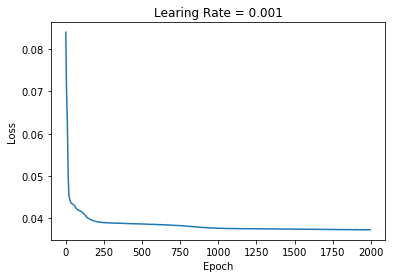

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
plt.plot(np.arange(0, epochs, 5), losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
ax=plt.title('Learing Rate = ' + str(learning_rate))